In [2]:
import os
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import time
import datetime
from IPython import display
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np 

In [3]:
import urllib
categories = [line.rstrip(b'\n') for line in urllib.request.urlopen('https://raw.githubusercontent.com/googlecreativelab/quickdraw-dataset/master/categories.txt')]
print(categories[:10])
category = 'candle'

[b'aircraft carrier', b'airplane', b'alarm clock', b'ambulance', b'angel', b'animal migration', b'ant', b'anvil', b'apple', b'arm']


In [4]:
# Creates a folder to download the original drawings into.
# We chose to use the numpy format : 1x784 pixel vectors, with values going from 0 (white) to 255 (black). We reshape them later to 28x28 grids and normalize the pixel intensity to [-1, 1]

if not os.path.isdir('npy_files'):
    os.mkdir('npy_files')
    
url = f'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/{category}.npy'  
urllib.request.urlretrieve(url, f'npy_files/{category}.npy')

images = np.load(f'npy_files/{category}.npy')
print(f'{len(images)} images to train on')

# You can limit the amount of images you use for training by setting :
train_images = images[:10000]
# You should also define a samller subset of the images for testing..
# TODO
test_images = images[10000:12000]

# Notice that this to numpy format contains 1x784 pixel vectors, with values going from 0 (white) to 255 (black). We reshape them later to 28x28 grids and normalize the pixel intensity to [-1, 1]

141545 images to train on


In [5]:
# create training and test tf.datasets
train_ds = tf.data.Dataset.from_tensor_slices(train_images)
test_ds = tf.data.Dataset.from_tensor_slices(test_images)

<TakeDataset shapes: (784,), types: tf.uint8>
<MapDataset shapes: (28, 28, 1), types: tf.float32>


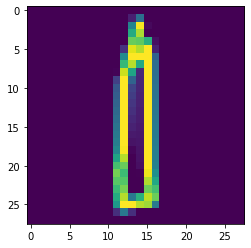

In [6]:
# print original and wanted shape and show image 
temp = test_ds.take(1)
print(temp)
temp = temp.map(lambda image: (tf.cast(tf.reshape(image, [28,28,1]), tf.float32)))
print(temp)
for elem in temp:
  plt.imshow(elem[ :, :, 0])

In [7]:
def prepare(ds):   
  # Prepare data for model  
  ds = ds.map(lambda img: (tf.cast(img, tf.float32)))
  ds = ds.map(lambda img:(tf.reshape(img, [28,28,1])))
  ds = ds.map(lambda img: ((img/128.)-1.))  
  # cache 
  ds = ds.cache()
  # shuffle, batch, prefetch our dataset
  ds = ds.shuffle(5000)
  ds = ds.batch(256)
  ds = ds.prefetch(1024)
  return ds

In [8]:
train_ds = prepare(train_ds)
test_ds = prepare(test_ds)

In [9]:
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Reshape, Conv2DTranspose, MaxPool2D, Dropout, BatchNormalization, LeakyReLU

In [10]:
class Discriminator(Model):

  def __init__(self):
    super(Discriminator, self).__init__()

    # list of loss and accuracy for training 
    self.metrics_list = [
      tf.keras.metrics.Mean(name="disc_loss"),
      tf.keras.metrics.BinaryAccuracy(name="disc_acc") ]

    self.discriminator = [
      Conv2D(32, (3,3), strides=(2, 2), activation='relu', padding='same', input_shape=[28, 28, 1]),
      BatchNormalization(),
      Dropout(0.3),

      Conv2D(64, (3,3), activation='relu', strides=(2, 2), padding='same'),
      BatchNormalization(),
      Dropout(0.3),

      Conv2D(32, (3,3), activation='relu', strides=(2, 2), padding='same'),
      BatchNormalization(),
      Dropout(0.3),
      
      Flatten(),
      Dense(1, activation='sigmoid')
      ]
  
  @tf.function
  def call(self, x, training=True):

    for layer in self.discriminator:
      x = layer(x, training=training)
    return x

  # function to reset the metric values
  def reset_metrics(self):
      for metric in self.metrics:
          metric.reset_states()

In [11]:
class Generator(Model):

  def __init__(self):
    super(Generator, self).__init__()

    # list of loss and accuracy for training 
    self.metrics_list = [
      tf.keras.metrics.Mean(name="gen_loss"),
      tf.keras.metrics.BinaryAccuracy(name="gen_acc") ]

    self.generator = [
      Dense(7*7*256, use_bias=False, input_shape=(100,)),
      BatchNormalization(),
      LeakyReLU(),

      Reshape((7,7,256)),

      Conv2DTranspose(64, (2,2), strides=(1,1), padding='same'),
      BatchNormalization(),
      LeakyReLU(),

      Conv2DTranspose(128, (2,2), strides=(2,2), padding='same'),
      BatchNormalization(),
      LeakyReLU(),

      Conv2DTranspose(128, (2,2), strides=(1,1), padding='same'),
      BatchNormalization(),
      LeakyReLU(),

      Conv2DTranspose(64, (2,2), strides=(1,1), padding='same'),
      BatchNormalization(),
      LeakyReLU(),
      
      Conv2DTranspose(filters= 1, kernel_size=(3, 3), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
      ]

  @tf.function
  def call(self, x, training=True):

    for layer in self.generator:
      x = layer(x, training=training)
    return x

  # function to reset the metric values
  def reset_metrics(self):
      for metric in self.metrics:
          metric.reset_states()

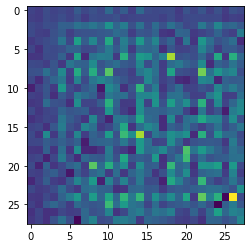

In [12]:
# test generator
sample_generator = Generator()

generated_image = sample_generator(tf.random.normal([1, 100]), training=False)

plt.imshow(generated_image[0, :, :, 0])

In [13]:
#test discriminator on generated image
test_discriminator = Discriminator()
result = test_discriminator(generated_image)
print(result)

tf.Tensor([[0.3861792]], shape=(1, 1), dtype=float32)


In [14]:
def generate_image(model, epoch, test_input):
  # `training` set to False.
  # This is so all layers run in inference mode (batchnorm)

  # get image from generator
  predictions = model(test_input, training=False)

  # plot image
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5)
      plt.axis('off')
  plt.show()

In [15]:
def discriminator_loss(real_output, fake_output, loss_func):
  # compute loss for discriminator
  real_loss = loss_func(tf.ones_like(real_output), real_output)
  fake_loss = loss_func(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

def generator_loss(fake_output, loss_func):
  # compute loss for generator
  return loss_func(tf.ones_like(fake_output), fake_output)

In [16]:
@tf.function
def train_step(images, loss_func):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise)

      real_output = discriminator(images)
      fake_output = discriminator(generated_images)

      gen_loss = generator_loss(fake_output, loss_func)
      disc_loss = discriminator_loss(real_output, fake_output, loss_func)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    gen_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    disc_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    # update loss metric
    discriminator.metrics[0].update_state(disc_loss)
    generator.metrics[0].update_state(gen_loss)
    
    # for all metrics except loss, update states (accuracy etc.)
    for metric in discriminator.metrics[1:]:
      metric.update_state(tf.ones_like(real_output), real_output)
      metric.update_state(tf.zeros_like(fake_output), fake_output)
    
    for metric in generator.metrics[1:]:
      metric.update_state(tf.ones_like(fake_output), fake_output)

    # Return a dictionary mapping metric names to current value
    disc_metrics = {m.name: m.result() for m in discriminator.metrics}
    gen_metrics = {m.name: m.result() for m in generator.metrics}
    return  gen_metrics , disc_metrics

def test_step(images, loss_func):
  generated_images = generator(noise, training=False)
  
  real_output = discriminator(images, training=False)
  fake_output = discriminator(generated_images, training=False)

  gen_loss = generator_loss(fake_output, loss_func)

  disc_loss = discriminator_loss(real_output, fake_output, loss_func)

  # update loss metric
  discriminator.metrics[0].update_state(disc_loss)
  generator.metrics[0].update_state(gen_loss)
  
  # for all metrics except loss, update states (accuracy etc.)
  for metric in discriminator.metrics[1:]:
    metric.update_state(tf.ones_like(real_output), real_output)
    metric.update_state(tf.zeros_like(fake_output), fake_output)
  
  for metric in generator.metrics[1:]:
    metric.update_state(tf.ones_like(fake_output), fake_output)

  # Return a dictionary mapping metric names to current value
  disc_metrics = {m.name: m.result() for m in discriminator.metrics}
  gen_metrics = {m.name: m.result() for m in generator.metrics}

  return  gen_metrics , disc_metrics

In [17]:
tf.keras.backend.clear_session()
def training(train_data, test_data, loss_function, epochs):
  # train models
  for epoch in range(epochs):
    print()
    print(f"Epoch {epoch}:")
    
    for data in train_data:
        gen_metrics, disc_metrics = train_step(data, loss_function)
                                    
    print("Discriminator")
    print([f"{key}: {value}" for (key, value) in zip(list(disc_metrics.keys()), list(disc_metrics.values()))])
    print("Generator")
    print([f"{key}: {value}" for (key, value) in zip(list(gen_metrics.keys()), list(gen_metrics.values()))])
    
    # logging the validation metrics to the log file with tensorboard
    with train_summary_writer.as_default():
        for metric in generator.metrics:
            tf.summary.scalar(f"{metric.name}", metric.result(), step=epoch)
        for metric in discriminator.metrics:
            tf.summary.scalar(f"{metric.name}", metric.result(), step=epoch)
        
    
    # reset metrics in models
    discriminator.reset_metrics()
    generator.reset_metrics()
    
    # test models
    for data in test_data:
        gen_metrics, disc_metrics = test_step(data, loss_function)
                                
    print("Discriminator")
    print([f"test_{key}: {value}" for (key, value) in zip(list(disc_metrics.keys()), list(disc_metrics.values()))])
    print("Generator")
    print([f"test_{key}: {value}" for (key, value) in zip(list(gen_metrics.keys()), list(gen_metrics.values()))])

    # show generated images                                              
    generate_image(generator, epoch + 1, seed)
    
    # logging the validation metrics to the log file with tensorboard
    with val_summary_writer.as_default():
        for metric in generator.metrics:
            tf.summary.scalar(f"{metric.name}", metric.result(), step=epoch)
        for metric in discriminator.metrics:
            tf.summary.scalar(f"{metric.name}", metric.result(), step=epoch)
    
    # reset metrics in models
    discriminator.reset_metrics()
    generator.reset_metrics()

In [18]:
# initialize models 
generator = Generator()
discriminator = Discriminator()

# hyperparameters
BATCH_SIZE = 256

EPOCHS = 50

LOSS_FUNC = tf.keras.losses.BinaryCrossentropy()

gen_optimizer = tf.keras.optimizers.Adam(0.001)
disc_optimizer = tf.keras.optimizers.Adam(0.001)

# additional parameters for noise creation
noise_dim = 100
num_examples_to_generate = 4

noise = tf.random.normal([1, 100])
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [19]:
# Define saving location for log
hyperparameter_string= f"Trial:02_BATCH:{BATCH_SIZE}_EPOCH:{EPOCHS}_Adam"
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

train_log_path = f"logs/{hyperparameter_string}/{current_time}/train"
val_log_path = f"logs/{hyperparameter_string}/{current_time}/val"

# log writer for training metrics
train_summary_writer = tf.summary.create_file_writer(train_log_path)

# log writer for validation metrics
val_summary_writer = tf.summary.create_file_writer(val_log_path)


Epoch 0:
Discriminator
['disc_loss: 1.6607977151870728', 'disc_acc: 0.6346837878227234']
Generator
['gen_loss: 0.6761208772659302', 'gen_acc: 0.661328136920929']
Discriminator
['test_disc_loss: 1.2945541143417358', 'test_disc_acc: 0.0044820718467235565']
Generator
['test_gen_loss: 1.1183152198791504', 'test_gen_acc: 0.0']


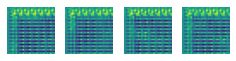


Epoch 1:
Discriminator
['disc_loss: 0.6732872724533081', 'disc_acc: 0.8525197505950928']
Generator
['gen_loss: 1.7163419723510742', 'gen_acc: 0.27128905057907104']
Discriminator
['test_disc_loss: 0.7004365921020508', 'test_disc_acc: 0.7191234827041626']
Generator
['test_gen_loss: 3.3427481651306152', 'test_gen_acc: 0.0']


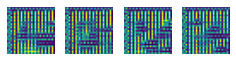


Epoch 2:
Discriminator
['disc_loss: 0.32900696992874146', 'disc_acc: 0.9385375380516052']
Generator
['gen_loss: 2.5110318660736084', 'gen_acc: 0.10185547173023224']
Discriminator
['test_disc_loss: 1.9581729173660278', 'test_disc_acc: 0.0039840638637542725']
Generator
['test_gen_loss: 4.696699619293213', 'test_gen_acc: 0.0']


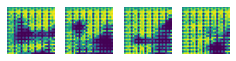


Epoch 3:
Discriminator
['disc_loss: 0.293832004070282', 'disc_acc: 0.947579026222229']
Generator
['gen_loss: 3.1973319053649902', 'gen_acc: 0.07568359375']
Discriminator
['test_disc_loss: 1.5558605194091797', 'test_disc_acc: 0.026394423097372055']
Generator
['test_gen_loss: 3.7951393127441406', 'test_gen_acc: 0.0']


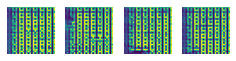


Epoch 4:
Discriminator
['disc_loss: 0.2159118354320526', 'disc_acc: 0.9665019512176514']
Generator
['gen_loss: 3.4532783031463623', 'gen_acc: 0.04082031175494194']
Discriminator
['test_disc_loss: 1.5700318813323975', 'test_disc_acc: 0.058266934007406235']
Generator
['test_gen_loss: 1.9573246240615845', 'test_gen_acc: 0.0']


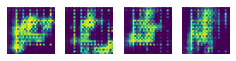


Epoch 5:
Discriminator
['disc_loss: 0.22018380463123322', 'disc_acc: 0.9653161764144897']
Generator
['gen_loss: 3.6668498516082764', 'gen_acc: 0.03730468824505806']
Discriminator
['test_disc_loss: 4.9315690994262695', 'test_disc_acc: 0.0039840638637542725']
Generator
['test_gen_loss: 7.891417980194092', 'test_gen_acc: 0.0']


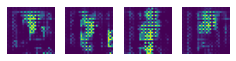


Epoch 6:
Discriminator
['disc_loss: 0.3173302114009857', 'disc_acc: 0.9440711736679077']
Generator
['gen_loss: 3.6157498359680176', 'gen_acc: 0.05107421800494194']
Discriminator
['test_disc_loss: 4.062647342681885', 'test_disc_acc: 0.0039840638637542725']
Generator
['test_gen_loss: 7.716475486755371', 'test_gen_acc: 0.0']


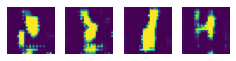


Epoch 7:
Discriminator
['disc_loss: 0.2699297368526459', 'disc_acc: 0.9549407362937927']
Generator
['gen_loss: 3.782442092895508', 'gen_acc: 0.03886718675494194']
Discriminator
['test_disc_loss: 4.652699947357178', 'test_disc_acc: 0.005478087812662125']
Generator
['test_gen_loss: 4.458506107330322', 'test_gen_acc: 0.0']


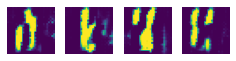


Epoch 8:
Discriminator
['disc_loss: 0.27424678206443787', 'disc_acc: 0.9534090757369995']
Generator
['gen_loss: 3.754283905029297', 'gen_acc: 0.04648437350988388']
Discriminator
['test_disc_loss: 0.08356049656867981', 'test_disc_acc: 0.9780876636505127']
Generator
['test_gen_loss: 6.941688537597656', 'test_gen_acc: 0.0']


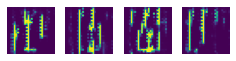


Epoch 9:
Discriminator
['disc_loss: 0.264364629983902', 'disc_acc: 0.9549407362937927']
Generator
['gen_loss: 3.551055908203125', 'gen_acc: 0.04414062574505806']
Discriminator
['test_disc_loss: 5.7357330322265625', 'test_disc_acc: 0.007968127727508545']
Generator
['test_gen_loss: 7.512580394744873', 'test_gen_acc: 0.0']


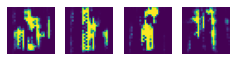


Epoch 10:
Discriminator
['disc_loss: 0.3362398147583008', 'disc_acc: 0.9374011754989624']
Generator
['gen_loss: 3.438185453414917', 'gen_acc: 0.06464843451976776']
Discriminator
['test_disc_loss: 4.9707818031311035', 'test_disc_acc: 0.016932271420955658']
Generator
['test_gen_loss: 9.173163414001465', 'test_gen_acc: 0.0']


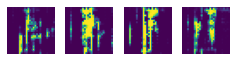


Epoch 11:
Discriminator
['disc_loss: 0.504720151424408', 'disc_acc: 0.8975790739059448']
Generator
['gen_loss: 3.366981029510498', 'gen_acc: 0.09609375149011612']
Discriminator
['test_disc_loss: 4.4803667068481445', 'test_disc_acc: 0.021414343267679214']
Generator
['test_gen_loss: 7.728455066680908', 'test_gen_acc: 0.0']


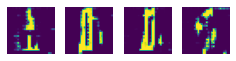


Epoch 12:
Discriminator
['disc_loss: 0.2070111334323883', 'disc_acc: 0.9665513634681702']
Generator
['gen_loss: 4.161108493804932', 'gen_acc: 0.03349609300494194']
Discriminator
['test_disc_loss: 1.03521728515625', 'test_disc_acc: 0.4810757040977478']
Generator
['test_gen_loss: 5.454753875732422', 'test_gen_acc: 0.0']


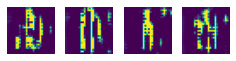


Epoch 13:
Discriminator
['disc_loss: 0.2112525999546051', 'disc_acc: 0.9644762873649597']
Generator
['gen_loss: 4.300108909606934', 'gen_acc: 0.03554687649011612']
Discriminator
['test_disc_loss: 3.604168176651001', 'test_disc_acc: 0.04780876636505127']
Generator
['test_gen_loss: 6.843932628631592', 'test_gen_acc: 0.0']


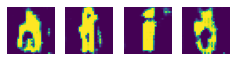


Epoch 14:
Discriminator
['disc_loss: 0.26893386244773865', 'disc_acc: 0.9517786502838135']
Generator
['gen_loss: 3.9498257637023926', 'gen_acc: 0.048828125']
Discriminator
['test_disc_loss: 5.825007438659668', 'test_disc_acc: 0.011454183608293533']
Generator
['test_gen_loss: 7.502169609069824', 'test_gen_acc: 0.0']


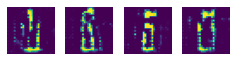


Epoch 15:
Discriminator
['disc_loss: 0.3980804979801178', 'disc_acc: 0.9198616743087769']
Generator
['gen_loss: 3.445812940597534', 'gen_acc: 0.07275390625']
Discriminator
['test_disc_loss: 8.917135238647461', 'test_disc_acc: 0.006474103778600693']
Generator
['test_gen_loss: 11.647665977478027', 'test_gen_acc: 0.0']


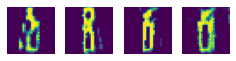


Epoch 16:
Discriminator
['disc_loss: 0.310090035200119', 'disc_acc: 0.9416996240615845']
Generator
['gen_loss: 4.014206886291504', 'gen_acc: 0.05361328274011612']
Discriminator
['test_disc_loss: 4.141623497009277', 'test_disc_acc: 0.022410359233617783']
Generator
['test_gen_loss: 6.431613445281982', 'test_gen_acc: 0.0']


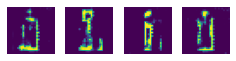


Epoch 17:
Discriminator
['disc_loss: 0.3146337866783142', 'disc_acc: 0.9403656125068665']
Generator
['gen_loss: 4.411454200744629', 'gen_acc: 0.06728515774011612']
Discriminator
['test_disc_loss: 5.692636966705322', 'test_disc_acc: 0.012450199574232101']
Generator
['test_gen_loss: 6.894049644470215', 'test_gen_acc: 0.0']


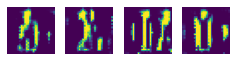


Epoch 18:
Discriminator
['disc_loss: 0.10766667127609253', 'disc_acc: 0.9840415120124817']
Generator
['gen_loss: 5.4481730461120605', 'gen_acc: 0.01689453050494194']
Discriminator
['test_disc_loss: 7.640483379364014', 'test_disc_acc: 0.006474103778600693']
Generator
['test_gen_loss: 8.32503890991211', 'test_gen_acc: 0.0']


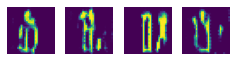


Epoch 19:
Discriminator
['disc_loss: 0.154234379529953', 'disc_acc: 0.9755434989929199']
Generator
['gen_loss: 4.8005266189575195', 'gen_acc: 0.02226562425494194']
Discriminator
['test_disc_loss: 5.608427047729492', 'test_disc_acc: 0.009462151676416397']
Generator
['test_gen_loss: 6.011877059936523', 'test_gen_acc: 0.0']


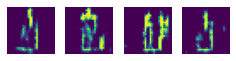


Epoch 20:
Discriminator
['disc_loss: 0.27566343545913696', 'disc_acc: 0.945652186870575']
Generator
['gen_loss: 4.482192039489746', 'gen_acc: 0.05341796949505806']
Discriminator
['test_disc_loss: 9.219331741333008', 'test_disc_acc: 0.005976095795631409']
Generator
['test_gen_loss: 10.755577087402344', 'test_gen_acc: 0.0']


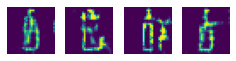


Epoch 21:
Discriminator
['disc_loss: 0.263422429561615', 'disc_acc: 0.9495059251785278']
Generator
['gen_loss: 4.546102046966553', 'gen_acc: 0.04521484300494194']
Discriminator
['test_disc_loss: 0.6675502061843872', 'test_disc_acc: 0.636454164981842']
Generator
['test_gen_loss: 3.117227554321289', 'test_gen_acc: 0.0']


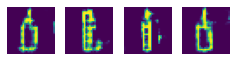


Epoch 22:
Discriminator
['disc_loss: 0.18126505613327026', 'disc_acc: 0.9665019512176514']
Generator
['gen_loss: 5.831172466278076', 'gen_acc: 0.03261718899011612']
Discriminator
['test_disc_loss: 2.2389488220214844', 'test_disc_acc: 0.15836653113365173']
Generator
['test_gen_loss: 3.7894978523254395', 'test_gen_acc: 0.0']


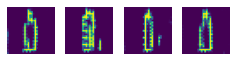


Epoch 23:
Discriminator
['disc_loss: 0.08960681408643723', 'disc_acc: 0.9852272868156433']
Generator
['gen_loss: 6.4091010093688965', 'gen_acc: 0.013964843936264515']
Discriminator
['test_disc_loss: 3.7895326614379883', 'test_disc_acc: 0.08017928153276443']
Generator
['test_gen_loss: 6.847586631774902', 'test_gen_acc: 0.0']


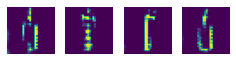


Epoch 24:
Discriminator
['disc_loss: 0.07420573383569717', 'disc_acc: 0.989426851272583']
Generator
['gen_loss: 6.275603294372559', 'gen_acc: 0.00820312462747097']
Discriminator
['test_disc_loss: 5.029953956604004', 'test_disc_acc: 0.052290838211774826']
Generator
['test_gen_loss: 7.521744728088379', 'test_gen_acc: 0.0']


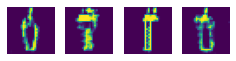


Epoch 25:
Discriminator
['disc_loss: 0.2451985627412796', 'disc_acc: 0.9532608985900879']
Generator
['gen_loss: 4.840596675872803', 'gen_acc: 0.04628906399011612']
Discriminator
['test_disc_loss: 5.98305082321167', 'test_disc_acc: 0.037350598722696304']
Generator
['test_gen_loss: 8.174705505371094', 'test_gen_acc: 0.0']


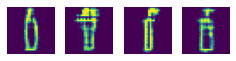


Epoch 26:
Discriminator
['disc_loss: 0.2884752154350281', 'disc_acc: 0.9422925114631653']
Generator
['gen_loss: 5.199671745300293', 'gen_acc: 0.05361328274011612']
Discriminator
['test_disc_loss: 3.85848331451416', 'test_disc_acc: 0.12599600851535797']
Generator
['test_gen_loss: 7.87150239944458', 'test_gen_acc: 0.0']


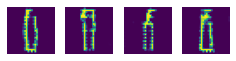


Epoch 27:
Discriminator
['disc_loss: 0.0954047217965126', 'disc_acc: 0.9852766990661621']
Generator
['gen_loss: 5.9413228034973145', 'gen_acc: 0.01308593712747097']
Discriminator
['test_disc_loss: 7.034937858581543', 'test_disc_acc: 0.04332669451832771']
Generator
['test_gen_loss: 10.20082950592041', 'test_gen_acc: 0.0']


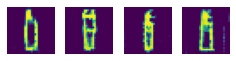


Epoch 28:
Discriminator
['disc_loss: 0.11828194558620453', 'disc_acc: 0.9814229011535645']
Generator
['gen_loss: 5.747931957244873', 'gen_acc: 0.015625']
Discriminator
['test_disc_loss: 1.337915062904358', 'test_disc_acc: 0.3720119595527649']
Generator
['test_gen_loss: 5.711935997009277', 'test_gen_acc: 0.0']


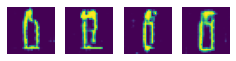


Epoch 29:
Discriminator
['disc_loss: 0.10732109844684601', 'disc_acc: 0.9816205501556396']
Generator
['gen_loss: 5.8814616203308105', 'gen_acc: 0.01865234412252903']
Discriminator
['test_disc_loss: 0.7902254462242126', 'test_disc_acc: 0.5742031931877136']
Generator
['test_gen_loss: 3.494297981262207', 'test_gen_acc: 0.0']


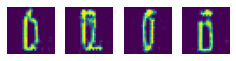


Epoch 30:
Discriminator
['disc_loss: 0.18494002521038055', 'disc_acc: 0.9670454263687134']
Generator
['gen_loss: 4.9350810050964355', 'gen_acc: 0.02910156175494194']
Discriminator
['test_disc_loss: 0.4502088129520416', 'test_disc_acc: 0.8580677509307861']
Generator
['test_gen_loss: 2.380164623260498', 'test_gen_acc: 0.0']


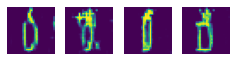


Epoch 31:
Discriminator
['disc_loss: 0.11674803495407104', 'disc_acc: 0.9851284623146057']
Generator
['gen_loss: 5.448713302612305', 'gen_acc: 0.01279296912252903']
Discriminator
['test_disc_loss: 2.3480961322784424', 'test_disc_acc: 0.995517909526825']
Generator
['test_gen_loss: 0.10100914537906647', 'test_gen_acc: 1.0']


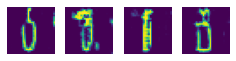


Epoch 32:
Discriminator
['disc_loss: 0.1209714263677597', 'disc_acc: 0.98013836145401']
Generator
['gen_loss: 5.944818496704102', 'gen_acc: 0.02255859412252903']
Discriminator
['test_disc_loss: 0.2737523317337036', 'test_disc_acc: 0.9676294922828674']
Generator
['test_gen_loss: 1.9395601749420166', 'test_gen_acc: 0.0']


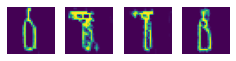


Epoch 33:
Discriminator
['disc_loss: 0.1123708114027977', 'disc_acc: 0.9834486246109009']
Generator
['gen_loss: 5.389108657836914', 'gen_acc: 0.014941406436264515']
Discriminator
['test_disc_loss: 3.1487631797790527', 'test_disc_acc: 0.9945219159126282']
Generator
['test_gen_loss: 0.04426289349794388', 'test_gen_acc: 1.0']


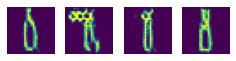


Epoch 34:
Discriminator
['disc_loss: 0.1280609667301178', 'disc_acc: 0.9784091114997864']
Generator
['gen_loss: 5.790642261505127', 'gen_acc: 0.02207031287252903']
Discriminator
['test_disc_loss: 0.2825819253921509', 'test_disc_acc: 0.8919322490692139']
Generator
['test_gen_loss: 5.989181041717529', 'test_gen_acc: 0.0']


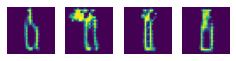


Epoch 35:
Discriminator
['disc_loss: 0.15149115025997162', 'disc_acc: 0.9741106629371643']
Generator
['gen_loss: 5.528738498687744', 'gen_acc: 0.02421874925494194']
Discriminator
['test_disc_loss: 3.699049472808838', 'test_disc_acc: 0.08515936136245728']
Generator
['test_gen_loss: 9.919350624084473', 'test_gen_acc: 0.0']


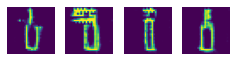


Epoch 36:
Discriminator
['disc_loss: 0.09155578911304474', 'disc_acc: 0.9845849871635437']
Generator
['gen_loss: 6.453381538391113', 'gen_acc: 0.01425781287252903']
Discriminator
['test_disc_loss: 3.1189708709716797', 'test_disc_acc: 0.1409362554550171']
Generator
['test_gen_loss: 10.894783973693848', 'test_gen_acc: 0.0']


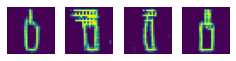


Epoch 37:
Discriminator
['disc_loss: 0.1059056892991066', 'disc_acc: 0.9834486246109009']
Generator
['gen_loss: 6.080321311950684', 'gen_acc: 0.0146484375']
Discriminator
['test_disc_loss: 2.840424060821533', 'test_disc_acc: 0.995517909526825']
Generator
['test_gen_loss: 0.061106085777282715', 'test_gen_acc: 1.0']


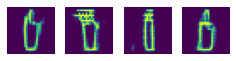


Epoch 38:
Discriminator
['disc_loss: 0.11108173429965973', 'disc_acc: 0.9812747240066528']
Generator
['gen_loss: 5.7027387619018555', 'gen_acc: 0.01816406287252903']
Discriminator
['test_disc_loss: 1.9836937189102173', 'test_disc_acc: 0.18924303352832794']
Generator
['test_gen_loss: 3.0103132724761963', 'test_gen_acc: 0.0']


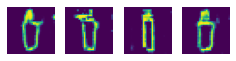


Epoch 39:
Discriminator
['disc_loss: 0.09721124917268753', 'disc_acc: 0.9830533862113953']
Generator
['gen_loss: 7.091189384460449', 'gen_acc: 0.01582031324505806']
Discriminator
['test_disc_loss: 3.4260950088500977', 'test_disc_acc: 0.1409362554550171']
Generator
['test_gen_loss: 6.72606897354126', 'test_gen_acc: 0.0']


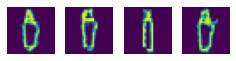


Epoch 40:
Discriminator
['disc_loss: 0.06910846382379532', 'disc_acc: 0.990464448928833']
Generator
['gen_loss: 6.566667079925537', 'gen_acc: 0.00830078125']
Discriminator
['test_disc_loss: 0.6270784139633179', 'test_disc_acc: 0.9920318722724915']
Generator
['test_gen_loss: 0.8734023571014404', 'test_gen_acc: 0.0']


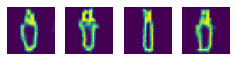


Epoch 41:
Discriminator
['disc_loss: 0.044049400836229324', 'disc_acc: 0.9944170117378235']
Generator
['gen_loss: 7.100235939025879', 'gen_acc: 0.0062500000931322575']
Discriminator
['test_disc_loss: 1.0596678256988525', 'test_disc_acc: 0.5941234827041626']
Generator
['test_gen_loss: 1.146604299545288', 'test_gen_acc: 0.0']


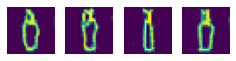


Epoch 42:
Discriminator
['disc_loss: 0.19352801144123077', 'disc_acc: 0.9646245241165161']
Generator
['gen_loss: 5.462844371795654', 'gen_acc: 0.03457031399011612']
Discriminator
['test_disc_loss: 4.514952659606934', 'test_disc_acc: 0.9950199127197266']
Generator
['test_gen_loss: 0.011082260869443417', 'test_gen_acc: 1.0']


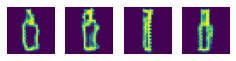


Epoch 43:
Discriminator
['disc_loss: 0.10549332201480865', 'disc_acc: 0.986709475517273']
Generator
['gen_loss: 6.641718864440918', 'gen_acc: 0.015429687686264515']
Discriminator
['test_disc_loss: 1.4472019672393799', 'test_disc_acc: 0.9920318722724915']
Generator
['test_gen_loss: 0.28345662355422974', 'test_gen_acc: 1.0']


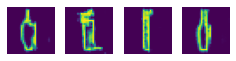


Epoch 44:
Discriminator
['disc_loss: 0.06661470979452133', 'disc_acc: 0.9883893132209778']
Generator
['gen_loss: 7.668557167053223', 'gen_acc: 0.013964843936264515']
Discriminator
['test_disc_loss: 1.362648367881775', 'test_disc_acc: 0.9905378222465515']
Generator
['test_gen_loss: 0.3076871335506439', 'test_gen_acc: 1.0']


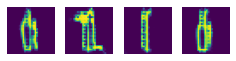


Epoch 45:
Discriminator
['disc_loss: 0.05232058838009834', 'disc_acc: 0.9916502237319946']
Generator
['gen_loss: 7.778326511383057', 'gen_acc: 0.00888671912252903']
Discriminator
['test_disc_loss: 5.759554862976074', 'test_disc_acc: 0.03585657477378845']
Generator
['test_gen_loss: 7.205476760864258', 'test_gen_acc: 0.0']


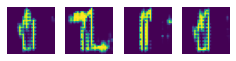


Epoch 46:
Discriminator
['disc_loss: 0.038058750331401825', 'disc_acc: 0.9946640133857727']
Generator
['gen_loss: 7.652840614318848', 'gen_acc: 0.006152343936264515']
Discriminator
['test_disc_loss: 5.565053939819336', 'test_disc_acc: 0.05428287014365196']
Generator
['test_gen_loss: 9.835870742797852', 'test_gen_acc: 0.0']


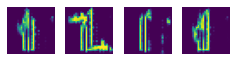


Epoch 47:
Discriminator
['disc_loss: 0.03809680417180061', 'disc_acc: 0.997035562992096']
Generator
['gen_loss: 8.793644905090332', 'gen_acc: 0.0025390624068677425']
Discriminator
['test_disc_loss: 0.1135067418217659', 'test_disc_acc: 0.982569694519043']
Generator
['test_gen_loss: 3.2872166633605957', 'test_gen_acc: 0.0']


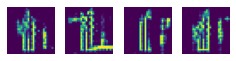


Epoch 48:
Discriminator
['disc_loss: 0.0304251816123724', 'disc_acc: 0.9947628378868103']
Generator
['gen_loss: 9.162841796875', 'gen_acc: 0.0087890625']
Discriminator
['test_disc_loss: 0.15356020629405975', 'test_disc_acc: 0.9716135263442993']
Generator
['test_gen_loss: 3.6273114681243896', 'test_gen_acc: 0.0']


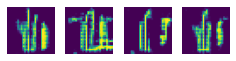


Epoch 49:
Discriminator
['disc_loss: 0.024778632447123528', 'disc_acc: 0.9966897368431091']
Generator
['gen_loss: 7.953986167907715', 'gen_acc: 0.0032226562034338713']
Discriminator
['test_disc_loss: 2.1267151832580566', 'test_disc_acc: 0.13197210431098938']
Generator
['test_gen_loss: 1.1076676845550537', 'test_gen_acc: 0.0']


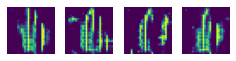

In [20]:
# train the GAN 
training(train_ds, test_ds, LOSS_FUNC, EPOCHS)

tf.Tensor([[8.838932e-09]], shape=(1, 1), dtype=float32)


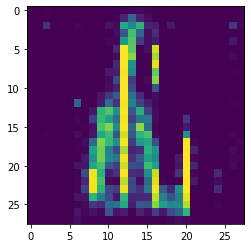

In [21]:
#test generator
image = generator(noise, training=False)

plt.imshow(image[0, :, :, 0])

#test discriminator 
result = discriminator(generated_image)
print(result)